# Scratch work for TensorFlow skills test (image recognition)

- Author: Chris Hodapp
- Date: 2017-11-28
- For SharpestMinds/Yazabi

## Links:

- [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers)
  - Using [train_32x32.mat](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) and [test_32x32.mat](http://ufldl.stanford.edu/housenumbers/test_32x32.mat) in `./data` directory
- AlexNet
  - [ImageNet Classification with Deep Convolutional Neural Networks (slides)](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf)
  - [ImageNet Classification with Deep Convolutional Neural Networks (paper)](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
  - https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/convnets.py#L231
  - https://dandxy89.github.io/ImageModels/alexnet/
  - [Local Response Normalization (LRN)](https://yeephycho.github.io/2016/08/03/Normalizations-in-neural-networks/#Local-Response-Normalization-LRN)
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## To do

1. Figure out AlexNet architecture adaptations needed here.
2. Test on actual images!
3. Training/validation split? (`normalize` signature prevents us from applying the same transformation to other images)
4. Should I be normalizing over all pixels, or over each pixel location?

In [46]:
import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dropout, Flatten, Input, merge, Dense, Activation
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.optimizers import SGD

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

# Data Loading

In [2]:
train = scipy.io.loadmat("data/train_32x32.mat")
test = scipy.io.loadmat("data/test_32x32.mat")

In [3]:
print(list(train.keys()))

['__header__', '__version__', '__globals__', 'X', 'y']


In [4]:
print(list(test.keys()))

['__header__', '__version__', '__globals__', 'X', 'y']


In [5]:
train_X, train_y = train["X"], train["y"].squeeze()
test_X, test_y = test["X"], test["y"].squeeze()

In [6]:
train_X.shape, train_y.shape

((32, 32, 3, 73257), (73257,))

In [7]:
test_X.shape, test_y.shape

((32, 32, 3, 26032), (26032,))

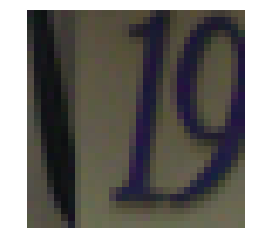

In [8]:
plt.imshow(train_X[:, :, :, 0])
plt.axis('off')
plt.show()

In [9]:
def stack_rgb(img):
    imgs = (img[:, :, 0], img[:, :, 1], img[:, :, 2])
    return np.concatenate(imgs, axis=1)

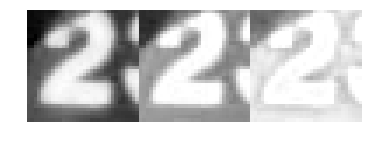

In [10]:
plt.imshow(stack_rgb(train_X[:, :, :, 2]), cmap='gray')
plt.axis('off')
plt.show()

In [11]:
# Standard NTSC/PAL luminance:
train_X_lum = 0.2989*train_X[:,:,0,:] + 0.5870*train_X[:,:,1,:] + 0.1140*train_X[:,:,2,:]
test_X_lum = 0.2989*test_X[:,:,0,:] + 0.5870*test_X[:,:,1,:] + 0.1140*test_X[:,:,2,:]

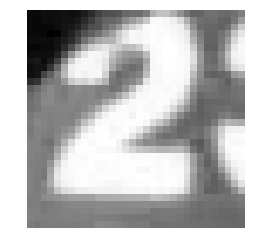

In [12]:
plt.imshow(train_X_lum[:, :, 2], cmap='gray')
plt.axis('off')
plt.show()

My guess:
- Luminance is meant to approximate the brightness we actually see. Images with similar luminance in foreground and background, but different colors, are probably then unlikely: it's just hard to read, and typically also ugly.
- However, color could still be a helpful proxy to help with foreground/background.

In [13]:
def normalize(images):
    """Converts input images to greyscale, and normalizes them
    (i.e. zero mean & unit variance for each pixel coordinate);
    returns a new array of images with shape (Y,X,N).
    
    Parameters:
    images -- Input array, shape (Y,X,3,N), for N color XxY images
    """
    r, g, b = images[:,:,0,:], images[:,:,1,:], images[:,:,2,:]
    img_lum = 0.2989*r + 0.5870*g + 0.1140*b
    # Note the axis=2. This normalization is per-pixel (though since
    # every pixel has been normalized, the aggregate mean & stdev
    # are also 0 and 1)
    mean = img_lum.mean(axis=2)[:,:,np.newaxis]
    stdev = img_lum.std(axis=2)[:,:,np.newaxis]
    img_norm = (img_lum - mean) / stdev
    return img_norm

In [14]:
train_X_norm = normalize(train_X)
train_X_norm.mean(), train_X_norm.std()

(1.0490779352118218e-15, 0.99999999999999878)

In [15]:
train_y.max()

10

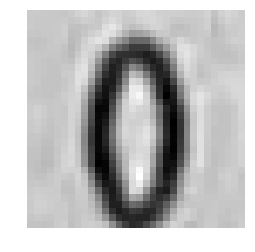

In [16]:
plt.imshow(train_X_lum[:,:,train_y == 10][:,:,4], cmap='gray')
plt.axis('off')
plt.show()

In [17]:
# Label of 10 appears to be the same as label of 0?
train_y[train_y == 10] = 0
train_y.max()

9

In [18]:
# Little lopsided (1 occurs 3 times as often as 0, 8, and 9):
for i in range(train_y.max() + 1):
    count = (train_y == i).sum()
    print("{0}: {1} ({2:.1f}%)".format(i, count, 100.0 * count / train_y.size))

0: 4948 (6.8%)
1: 13861 (18.9%)
2: 10585 (14.4%)
3: 8497 (11.6%)
4: 7458 (10.2%)
5: 6882 (9.4%)
6: 5727 (7.8%)
7: 5595 (7.6%)
8: 5045 (6.9%)
9: 4659 (6.4%)


## TensorFlow/Keras tests

In [19]:
import data_preprocessing

In [40]:
from tensorflow.python.client import device_lib

for x in device_lib.list_local_devices():
    print("{0.name}, {0.device_type}, {0.memory_limit}".format(x))

/cpu:0, CPU, 268435456
/device:XLA_CPU:0, XLA_CPU, 17179869184
/device:XLA_GPU:0, XLA_GPU, 17179869184
/device:XLA_EXEC:0, XLA_EXEC, 17179869184
/gpu:0, GPU, 173211648


In [72]:
train_X_orig, train_y_orig, _, _ = data_preprocessing.load_data()
train_X_norm = data_preprocessing.normalize(train_X_orig)
train_X, valid_X, train_y, valid_y = data_preprocessing.split(
    train_X_norm, train_y_orig)
# 'split' is deterministic. If we want to look at the images later,
# we can pass the un-normalized ones in and it will correspond with
# the same split:
train_X_unnorm, valid_X_unnorm, _, _ = data_preprocessing.split(
    train_X_orig, train_y_orig)

In [21]:
# Adapted from:
# https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/customlayers.py#L9
def lrn(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    def f(X):
        b, r, c, ch = X.shape
        half = n // 2
        square = keras.backend.square(X)
        # TODO: Fix padding here. The scale += ... line is failing.
        extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0, 0), (half, half)))
        extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
        scale = k
        for i in range(n):
            scale += alpha * extra_channels[:, :, :, i:i + int(ch)]
        scale = scale ** beta
        return X / scale

    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [22]:
# Inspired by:
# https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/convnets.py#L231
# TODO:
# Cross-channel normalization?
# Can I get rid of 'merge' since I'm not using two GPUs?
def AlexNet(input_shape=(227, 227, 3), output_count=1000):
    inputs = Input(shape=input_shape)

    #conv_1 = Conv2D(96, kernel_size=(11,11), strides=(4, 4), activation='relu', name='conv_1')(inputs)

    #conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1)
    #conv_2 = lrn(name='convpool_1')(conv_2)
    #conv_2 = ZeroPadding2D((2, 2))(conv_2)
    #conv_2 = Conv2D(256, kernel_size=(5,5), activation='relu', name='conv_2')(conv_2)
    conv_2 = Conv2D(256, kernel_size=(5,5), activation='relu', name='conv_2')(inputs)
    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    conv_3 = lrn()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv_3')(conv_3)
    conv_4 = ZeroPadding2D((1, 1))(conv_3)
    conv_4 = Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv_4')(conv_4)
    conv_5 = ZeroPadding2D((1, 1))(conv_4)
    conv_5 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv_5')(conv_5)
    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name='convpool_5')(conv_5)
    dense_1 = Flatten(name='flatten')(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1')(dense_1)
    dense_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(4096, activation='relu', name='dense_2')(dense_2)
    dense_3 = Dropout(0.5)(dense_2)
    dense_3 = Dense(output_count, name='dense_3')(dense_3)
    prediction = Activation('softmax', name='softmax')(dense_3)

    model = Model(input=inputs, output=prediction)

    return model

In [23]:
alex = AlexNet((32,32,1), 10)

/nix/store/wp8vkmipl73ph4iqdml29sqcv43746si-python3-3.6.3-env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


In [24]:
# One-hot encode so they can be used for input/validation:
train_y_cat = keras.utils.to_categorical(train_y, num_classes=10)
valid_y_cat = keras.utils.to_categorical(valid_y, num_classes=10)

In [25]:
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)
alex.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

train_X2 = np.expand_dims(train_X, axis=3)
valid_X2 = np.expand_dims(valid_X, axis=3)

history = alex.fit(train_X2,
                   train_y_cat,
                   epochs=10,
                   batch_size=64,
                   validation_data=(valid_X2, valid_y_cat))

Train on 54942 samples, validate on 18315 samples
Epoch 1/10
54942/54942 [==============================] - 90s - loss: 0.9133 - acc: 0.6954 - val_loss: 0.3790 - val_acc: 0.8897
Epoch 2/10
54942/54942 [==============================] - 87s - loss: 0.3527 - acc: 0.8946 - val_loss: 0.3149 - val_acc: 0.9071
Epoch 3/10
54942/54942 [==============================] - 87s - loss: 0.2772 - acc: 0.9177 - val_loss: 0.2746 - val_acc: 0.9203
Epoch 4/10
54942/54942 [==============================] - 89s - loss: 0.2324 - acc: 0.9316 - val_loss: 0.2537 - val_acc: 0.9282
Epoch 5/10
54942/54942 [==============================] - 91s - loss: 0.1951 - acc: 0.9434 - val_loss: 0.2670 - val_acc: 0.9260
Epoch 6/10
54942/54942 [==============================] - 91s - loss: 0.1657 - acc: 0.9521 - val_loss: 0.2535 - val_acc: 0.9319
Epoch 7/10
54942/54942 [==============================] - 91s - loss: 0.1418 - acc: 0.9582 - val_loss: 0.2800 - val_acc: 0.9293
Epoch 8/10
54942/54942 [==============================

In [48]:
valid_y_predict = np.argmax(alex.predict(valid_X2), axis=1)
# Confusion matrix (on validation set):
conf = sklearn.metrics.confusion_matrix(valid_y, valid_y_predict)
conf = pd.DataFrame(conf, columns=range(10), index=range(10))
conf

,0,1,2,3,4,5,6,7,8,9
0,1174,24,5,1,3,0,15,1,3,11
1,15,3280,28,24,40,7,17,39,11,4
2,6,20,2524,20,15,4,6,19,10,22
3,9,22,29,1960,8,46,6,10,21,13
4,5,33,28,14,1747,6,8,2,10,12
5,1,11,14,52,9,1585,30,3,4,12
6,18,11,4,5,12,22,1315,3,35,7
7,6,26,35,10,0,3,1,1308,2,8
8,22,20,16,17,6,7,36,4,1121,12
9,25,6,23,18,6,16,1,5,12,1053


In [61]:
# Stolen from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

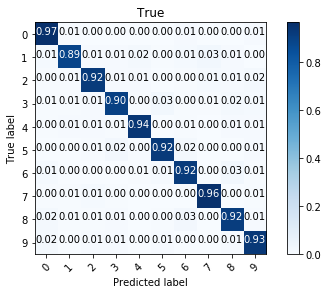

In [75]:
conf_norm = conf / conf.sum(axis=1)
plot_confusion_matrix(conf_norm.values, [str(i) for i in range(10)], True)
plt.show()

- It's also possible to show - in the same shape as the above matrix - an example of every misclassification:

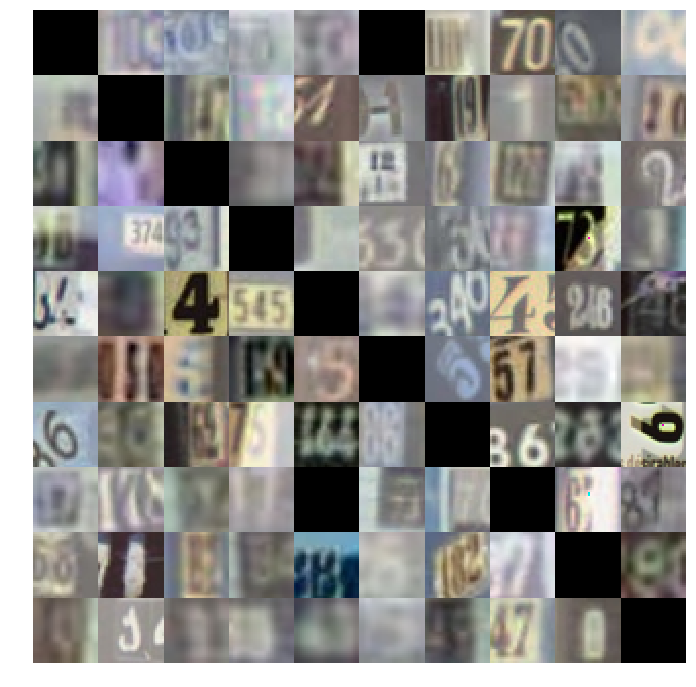

In [116]:
grid = np.zeros((32 * 10, 32 * 10, 3))
for i,j in [(i,j) for i in range(10) for j in range(10)]:
    # Leave diagonals blank (we don't care about correct ones):
    if i == j: continue
    # Find all cases where i is classified as j:
    idxs = ((valid_y == i) & (valid_y_predict == j)).nonzero()[0]
    # Pick one at random if one exists, and fill in grid:
    if idxs.size == 0: continue
    grid[(32*i):32*(i+1), (32*j):32*(j+1), :] = valid_X_unnorm[np.random.choice(idxs), :, :, :]
# I don't feel like wrangling matplotlib into showing this, so:
# Rows 0-9 are the correct labels.
# Columns 0-9 are the predicted labels.
plt.figure(figsize=(12,12))
plt.imshow(grid)
plt.axis('off')
plt.show()

Error classes:
- Multiple numbers
- Rotated, slanted, or sheared numbers
- Odd fonts, handwritten numbers
- Just too blurry to tell?